In [1]:
import os
os.environ["KERAS_BACKEND"] = "theano"

import csv
import itertools
import os
import re
import pandas as pd
import numpy as np

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,GRU, Bidirectional, TimeDistributed, Flatten
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.utils.np_utils import to_categorical

from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
#from keras.utils.np_utils import to_cat

from keras import backend as K
from keras import optimizers


import gensim
from gensim.summarization.textcleaner import clean_text_by_word
from gensim.summarization.textcleaner import clean_text_by_sentences
from gensim.summarization.textcleaner import split_sentences
from gensim.summarization.textcleaner import tokenize_by_word
from gensim.summarization.textcleaner import join_words
from gensim.models import KeyedVectors
#upload embedding
#from tqdm import tqdm, tnrange

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import resample


from sklearn.feature_selection import chi2, SelectKBest, SelectFromModel
import numpy as np

from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, f1_score, confusion_matrix, recall_score, precision_score

from scipy.sparse import *
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy import interp


path="/home/RDC/crajapax/crajapax/DataCollection/SavedExports/"
import cloudpickle as pickle

Using Theano backend.


In [2]:
X=pd.read_csv('/home/RDC/crajapax/crajapax/DataCollection/Datasheets/XCompTextNewCopy1.csv', sep =',')

In [3]:
path="/home/RDC/crajapax/crajapax/DataCollection/Results/SavedExports/"
import cloudpickle as pickle

def save_obj(obj, name ):
    with open(path+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name):   
    with open(path + name, 'rb') as f:
        
        return pickle.load(f)

In [4]:
embedding_matrix=load_obj("embedding_matrix_lower.pkl")
word_index=load_obj("word_index_lower.pkl")
maxlen=38
max_sentences=907
embedding_dim=300
mdas=load_obj("mdas_lower.pkl")

In [5]:
data = load_obj("data_lower.pkl")
labels = load_obj("labels_lower.pkl")

# Model Calibration

In [7]:
import HanModelsCombi as M

In [8]:
train,val,test=M.split_df(X, "target", 0.7, 0.15, 0.15)

Total:  1163
Training:  814 , Percentage:  0.6999140154772141
Validation:  174 , Percentage:  0.14961306964746346
Test: 175 , Percentage:  0.15047291487532244


In [9]:
#define train/test k for this fold
x_train, x_test, x_val = data[train.index], data[test.index], data[val.index]
y_train, y_test, y_val = labels[train.index], labels[test.index], labels[val.index]

In [10]:
y_train, y_test, y_val = labels[train.index], labels[test.index], labels[val.index]

In [11]:
print('Number of NoFraud and Fraud MDAs in training, validation and test set')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Number of NoFraud and Fraud MDAs in training, validation and test set
[673. 141.]
[144.  30.]
[145.  30.]


In [126]:
XQ=X[['AccRec.DbtsT', 'Sales.TurnNt', 'COGS.costsgd', 'Assets.Total',
       'CurrAssetTot', 'PPE.TotalNet', 'DeprAmortTot', 'AmrtOfIntang',
       'SG.A.Expense', 'LT.Debt.Totl', 'CurrLiabsTot', 'Income.IBEXi',
       'Oper.Act.NCF', 'Fin.Actv.NCF', 'Comm.OrdinEQ', 'ComSharOutst',
       'CashSTInvest', 'InventTotQtl', 'DeferrTaxInc', 'GrProfitMarg',
       'EBIT.Marginn', 'NtProfitMarg', 'CashFLMargin', 'ROA.finratio',
       'ROE.RnCommEQ', 'EBITDAMargin', 'Acc.Payables', 'InventoryPrx','DSR', 'GMI', 'AQI', 'SGI', 'DEPI', 'SGAI', 'LEVI', 'ACCRUALS', 'PROBM',
       'AverageTA', 'CFF', 'Leverage', 'dWC_Accruals', 'dReceivables',
       'dInventories', 'dEarnings', 'dCash_Sales', 'dCash_Margin',
       'dDef_Tax_Expense']]

In [127]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#Comp Data
#dfsubset.iloc[:, 14:78]
#Ling Dat
#dfsubset.iloc[:, 78:]
#XQ is the qualitative (dense) features
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#XQ=X.iloc[:, 14:].drop(["Office","Industry.Title","preV2"],axis=1)
from numpy import float32
XQ = XQ.astype(float32)
XQ=XQ.replace(-np.inf,-3.0028235e+38)
XQ=XQ.replace(np.inf,3.0028235e+38)
sc =MinMaxScaler(copy=True,feature_range=(0,1)) 
XQ = sc.fit_transform(XQ)


In [128]:
XQ_train, XQ_test, XQ_val=XQ[train.index], XQ[test.index], XQ[val.index]

In [18]:
class AttentionLayer(Layer):
    """
    Hierarchial Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    Theano backend
    """
    def __init__(self,attention_dim=300,return_coefficients=False,**kwargs):
        # Initializer 
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self.trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, hit, mask=None):
        # Here, the actual calculation is done
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

In [19]:
from sklearn.decomposition import PCA

In [30]:

    #Create Keras functional model for hierarchical attention network
    
embedding_layer = Embedding(len(word_index) + 1,embedding_dim,weights=[embedding_matrix], 
                                input_length=maxlen, trainable=False,name='word_embedding')

    # Words level attention model
word_input = Input(shape=(maxlen, ), dtype='int32',name='word_input')
word_sequences = embedding_layer(word_input)
word_lstm = Bidirectional(LSTM(50, return_sequences=True),name='word_lstm')(word_sequences)

word_dense = Dense(100, activation='relu', name='word_dense')(word_lstm) 
word_att,word_coeffs = AttentionLayer(embedding_dim,True,name='word_attention')(word_dense)
#word_drop = Dropout(0.3,name='word_dropout')(word_att)
wordEncoder = Model(inputs = word_input,outputs = word_att)
    
# Sentence level attention model
sent_input = Input(shape=(max_sentences,maxlen), dtype='int32',name='sent_input')
sent_encoder = TimeDistributed(wordEncoder,name='sent_linking')(sent_input)
sent_lstm = Bidirectional(LSTM(50, return_sequences=True),name='sent_lstm')(sent_encoder)
sent_dense = Dense(100, activation='relu', name='sent_dense')(sent_lstm) 
sent_att,sent_coeffs = AttentionLayer(embedding_dim,return_coefficients=True,name='sent_attention')(sent_dense)
sent_drop = Dropout(0.5,name='sent_dropout')(sent_att)

# Numerical Feature model
meta_input = Input(shape=(47,), name='meta_input')

x = concatenate([sent_drop, meta_input])
x = Dense(6, activation='relu')(x)

preds = Dense(2, activation='softmax',name='output')(x)

        # Model compile
model = Model([sent_input,meta_input], preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
        
print(wordEncoder.summary())
print(model.summary())
#return model, sent_input, sent_coeffs



Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_input (InputLayer)      (None, 38)                0         
_________________________________________________________________
word_embedding (Embedding)   (None, 38, 300)           9056100   
_________________________________________________________________
word_lstm (Bidirectional)    (None, 38, 100)           140400    
_________________________________________________________________
word_dense (Dense)           (None, 38, 100)           10100     
_________________________________________________________________
word_attention (AttentionLay [(None, 100), (None, 100, 30600     
Total params: 9,267,800
Trainable params: 181,100
Non-trainable params: 9,086,700
_________________________________________________________________
None
Model: "model_4"
_______________________________________________________________________________________

In [31]:
#model1=HAN(embedding_matrix,word_index,maxlen,max_sentences,50,100,6)

In [32]:
from keras.callbacks import Callback, ModelCheckpoint,EarlyStopping

In [33]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            #print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score,sensitivity,specificity)
    
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [34]:
RocAuc = RocAucEvaluation(validation_data=([x_val,XQ_val], y_val), interval=1)

In [35]:
#parameters=[(50,100,6),(150,200,6),(300,200,6)]

In [36]:
checkpointer = ModelCheckpoint("lower2.{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

In [37]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [38]:
Han1 = model.fit([x_train,XQ_train], y_train, validation_data=([x_val,XQ_val], y_val), epochs=12, batch_size=32,callbacks=[RocAuc,checkpointer,early_stop])


Train on 814 samples, validate on 174 samples
Epoch 1/12
814/814 [==============================] - 1717s 2s/step - loss: 0.4841 - acc: 0.8268 - val_loss: 0.4684 - val_acc: 0.8276

 ROC-AUC - epoch: 1 - score: 0.385648 

Epoch 2/12
814/814 [==============================] - 1694s 2s/step - loss: 0.4632 - acc: 0.8268 - val_loss: 0.4627 - val_acc: 0.8276

 ROC-AUC - epoch: 2 - score: 0.441667 

Epoch 3/12
814/814 [==============================] - 1698s 2s/step - loss: 0.4602 - acc: 0.8268 - val_loss: 0.4588 - val_acc: 0.8276

 ROC-AUC - epoch: 3 - score: 0.483796 

Epoch 4/12
814/814 [==============================] - 1694s 2s/step - loss: 0.4614 - acc: 0.8268 - val_loss: 0.4575 - val_acc: 0.8276

 ROC-AUC - epoch: 4 - score: 0.551157 

Epoch 5/12
814/814 [==============================] - 1688s 2s/step - loss: 0.4578 - acc: 0.8268 - val_loss: 0.4537 - val_acc: 0.8276

 ROC-AUC - epoch: 5 - score: 0.553472 

Epoch 6/12
814/814 [==============================] - 1701s 2s/step - loss: 0.4

In [39]:
Han1 = model.fit([x_train,XQ_train], y_train, validation_data=([x_val,XQ_val], y_val), epochs=4, batch_size=32,callbacks=[RocAuc,checkpointer])


Train on 814 samples, validate on 174 samples
Epoch 1/4
The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.
814/814 [==============================] - 1698s 2s/step - loss: 0.4333 - acc: 0.8268 - val_loss: 0.4173 - val_acc: 0.8276

 ROC-AUC - epoch: 1 - score: 0.733333 

Epoch 2/4
814/814 [==============================] - 1871s 2s/step - loss: 0.4218 - acc: 0.8268 - val_loss: 0.4148 - val_acc: 0.8276

 ROC-AUC - epoch: 2 - score: 0.728009 

Epoch 3/4
814/814 [==============================] - 1884s 2s/step - loss: 0.4109 - acc: 0.8268 - val_loss: 0.4655 - val_acc: 0.8276

 ROC-AUC - epoch: 3 - score: 0.713889 

Epoch 4/4
814/814 [==============================] - 1895s 2s/step - loss: 0.4208 - acc: 0.8268 - val_loss: 0.4070 - val_acc: 0.8276

 ROC-AUC - epoch: 4 - score: 0.734028 



In [136]:
Han1 = model.fit([x_train,XQ_train], y_train, validation_data=([x_val,XQ_val], y_val), epochs=2, batch_size=32,callbacks=[RocAuc,checkpointer])


Train on 814 samples, validate on 174 samples
Epoch 1/2
814/814 [==============================] - 1742s 2s/step - loss: 0.0980 - acc: 0.9730 - val_loss: 0.4297 - val_acc: 0.8276

 ROC-AUC - epoch: 1 - score: 0.871296 

Epoch 2/2
814/814 [==============================] - 2945s 4s/step - loss: 0.0756 - acc: 0.9717 - val_loss: 0.3609 - val_acc: 0.9195

 ROC-AUC - epoch: 2 - score: 0.906019 



In [150]:
Han1 = model.fit([x_train,XQ_train], y_train, validation_data=([x_val,XQ_val], y_val), epochs=2, batch_size=32,callbacks=[RocAuc,checkpointer])


Train on 814 samples, validate on 174 samples
Epoch 1/2
814/814 [==============================] - 2941s 4s/step - loss: 0.0854 - acc: 0.9779 - val_loss: 0.3801 - val_acc: 0.8736

 ROC-AUC - epoch: 1 - score: 0.887269 

Epoch 2/2
814/814 [==============================] - 2982s 4s/step - loss: 0.0588 - acc: 0.9840 - val_loss: 0.3210 - val_acc: 0.9023

 ROC-AUC - epoch: 2 - score: 0.900463 



In [67]:
from sklearn.metrics import roc_curve, auc, roc_auc_score,recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# HAN Model Evaluation on Val Set

In [139]:
#Model Evaluation on Val Set
loss_val, acc_val= model.evaluate([x_val,XQ_val], y_val)

174/174 [==============================] - 212s 1s/step


In [140]:
print(acc_val)
print(loss_val)
#print(sens_val)
#print(spec_val)

0.9195402264595032
0.3609221954455321


In [141]:
y_pred_val=model.predict([x_val,XQ_val],callbacks=[RocAuc])

In [142]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, f1_score, confusion_matrix, recall_score, precision_score

In [143]:
score_val=roc_auc_score(y_val,y_pred_val)
print(score_val)

0.9060185185185186


In [144]:
#to calculat teh roc_auc and test, y_pred_val1 are pred for the label=1, y_val1 are the 0..1 for label 1
y_val1=[y_val[k][1] for k in range(len(y_val))]
y_pred_val1=[y_pred_val[k][1] for k in range(len(y_pred_val))]
#this is the treshold for 50%
y_pred_val2 = np.argmax(y_pred_val, axis=1)

In [145]:
fpr, tpr, thresholds = roc_curve(y_val1,y_pred_val1)

In [146]:
auc(fpr, tpr)

0.9060185185185184

In [147]:
cm_val=confusion_matrix(y_val1,y_pred_val2)
total_val = sum(sum(cm_val))
acc_val2 = (cm_val[0, 0] + cm_val[1, 1]) / total_val
specificity_val = cm_val[0, 0] / (cm_val[0, 0] + cm_val[0, 1])
sensitivity_val = cm_val[1, 1] / (cm_val[1, 0] + cm_val[1, 1])
score_val2=roc_auc_score(y_val1,y_pred_val2)
print(acc_val2,score_val2,sensitivity_val,specificity_val)

0.9195402298850575 0.7666666666666666 0.5333333333333333 1.0


# HAN Model Evaluation on Test Set

In [137]:
#Model Evaluation on Test Set
loss_test, acc_test= model.evaluate([x_test,XQ_test], y_test)
print("Test set accuracy: ",acc_test)
print("Test set loss: ", loss_test)

175/175 [==============================] - 214s 1s/step
Test set accuracy:  0.8799999952316284
Test set loss:  0.48310773049082073


In [138]:
y_pred_test=model.predict([x_test,XQ_test])
score_test=roc_auc_score(y_test,y_pred_test)
print(score_test)

0.8733333333333333


In [148]:
#to calculat teh roc_auc and test, y_pred_val1 are pred for the label=1, y_val1 are the 0..1 for label 1
y_test1=[y_test[k][1] for k in range(len(y_test))]
y_pred_test1=[y_pred_test[k][1] for k in range(len(y_pred_test))]
#this is the treshold for 50%
y_pred_test2 = np.argmax(y_pred_test, axis=1)

In [149]:
cm_test=confusion_matrix(y_test1,y_pred_test2)
total_test = sum(sum(cm_test))
acc_test2 = (cm_test[0, 0] + cm_test[1, 1]) / total_test
specificity_test = cm_test[0, 0] / (cm_test[0, 0] + cm_test[0, 1])
sensitivity_test = cm_test[1, 1] / (cm_test[1, 0] + cm_test[1, 1])
score_test2=roc_auc_score(y_test1,y_pred_test2)
print(acc_test2,score_test2,sensitivity_test,specificity_test)

0.88 0.6764367816091954 0.36666666666666664 0.9862068965517241


# ML Model Validation Set

In [86]:
#all variables Ling plus Compustat plus Tfidf, run all with ModelCombi, and with Baseline to get only com and ling
#XQ=X.iloc[:, 14:].drop(["Office","Industry.Title","preV2"],axis=1)
XQ=X[['AccRec.DbtsT', 'Sales.TurnNt', 'COGS.costsgd', 'Assets.Total',
       'CurrAssetTot', 'PPE.TotalNet', 'DeprAmortTot', 'AmrtOfIntang',
       'SG.A.Expense', 'LT.Debt.Totl', 'CurrLiabsTot', 'Income.IBEXi',
       'Oper.Act.NCF', 'Fin.Actv.NCF', 'Comm.OrdinEQ', 'ComSharOutst',
       'CashSTInvest', 'InventTotQtl', 'DeferrTaxInc', 'GrProfitMarg',
       'EBIT.Marginn', 'NtProfitMarg', 'CashFLMargin', 'ROA.finratio',
       'ROE.RnCommEQ', 'EBITDAMargin', 'Acc.Payables', 'InventoryPrx','DSR', 'GMI', 'AQI', 'SGI', 'DEPI', 'SGAI', 'LEVI', 'ACCRUALS', 'PROBM',
       'AverageTA', 'CFF', 'Leverage', 'dWC_Accruals', 'dReceivables',
       'dInventories', 'dEarnings', 'dCash_Sales', 'dCash_Margin',
       'dDef_Tax_Expense', 'mda_positive_score',
       'mda_negative_score', 'mda_polarity_score',
       'mda_average_sentence_length', 'mda_percentage_of_complex_words',
       'mda_fog_index', 'mda_complex_word_count', 'mda_word_count',
       'mda_uncertainty_score', 'mda_constraining_score',
       'mda_positive_word_proportion', 'mda_negative_word_proportion',
       'mda_uncertainty_word_proportion', 'mda_constraining_word_proportion']]

from numpy import float32
XQ = XQ.astype(float32)
XQ=XQ.replace(-np.inf,-3.0028235e+38)
XQ=XQ.replace(np.inf,3.0028235e+38)

sc =MinMaxScaler(copy=True,feature_range=(0,1)) 
XQ[XQ.columns] = sc.fit_transform(XQ[XQ.columns])
XQ_train, XQ_test, XQ_val=XQ.iloc[train.index], XQ.iloc[test.index], XQ.iloc[val.index]

In [87]:
#only words from tfid and compustat run with ModelCombi
#only Compustat run with Baseline
#XQ2=X.iloc[:, 14:78]
XQ2=X[['AccRec.DbtsT', 'Sales.TurnNt', 'COGS.costsgd', 'Assets.Total',
       'CurrAssetTot', 'PPE.TotalNet', 'DeprAmortTot', 'AmrtOfIntang',
       'SG.A.Expense', 'LT.Debt.Totl', 'CurrLiabsTot', 'Income.IBEXi',
       'Oper.Act.NCF', 'Fin.Actv.NCF', 'Comm.OrdinEQ', 'ComSharOutst',
       'CashSTInvest', 'InventTotQtl', 'DeferrTaxInc', 'GrProfitMarg',
       'EBIT.Marginn', 'NtProfitMarg', 'CashFLMargin', 'ROA.finratio',
       'ROE.RnCommEQ', 'EBITDAMargin', 'Acc.Payables', 'InventoryPrx','DSR', 'GMI', 'AQI', 'SGI', 'DEPI', 'SGAI', 'LEVI', 'ACCRUALS', 'PROBM',
       'AverageTA', 'CFF', 'Leverage', 'dWC_Accruals', 'dReceivables',
       'dInventories', 'dEarnings', 'dCash_Sales', 'dCash_Margin',
       'dDef_Tax_Expense']]
from numpy import float32
XQ2 = XQ2.astype(float32)
XQ2=XQ2.replace(-np.inf,-3.0028235e+38)
XQ2=XQ2.replace(np.inf,3.0028235e+38)

sc =MinMaxScaler(copy=True,feature_range=(0,1)) 
XQ2[XQ2.columns] = sc.fit_transform(XQ2[XQ2.columns])
XQ2_train, XQ2_test, XQ2_val=XQ2.iloc[train.index], XQ2.iloc[test.index], XQ2.iloc[val.index]

In [88]:
x2_train=pd.concat([X["pre2"].iloc[train.index],XQ_train], axis=1)
y2_train=X["target"].iloc[train.index]
x2_val=pd.concat([X["pre2"].iloc[val.index],XQ_val], axis=1)
y2_val=X["target"].iloc[val.index]
x2_test=pd.concat([X["pre2"].iloc[test.index],XQ_test], axis=1)
y2_test=X["target"].iloc[test.index]

In [96]:
MLmodels_val2=CombiModelsEval("None",0,x2_train,x2_val,y2_train,y2_val)
#BMLmodels_val2=CombiModelsEval("None",0,x2_train,x2_val,y2_train,y2_val)
Baselinemodels_val2=Baseline("None",0,x2_train,x2_val,y2_train,y2_val)
#CompOnlyBaselinemodels_val2=Baseline("None",0,x2_train,x2_val,y2_train,y2_val)


(814, 18088)


/home/RDC/crajapax/.conda/envs/kerasspring/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/RDC/crajapax/.conda/envs/kerasspring/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(814, 61)


/home/RDC/crajapax/.conda/envs/kerasspring/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/RDC/crajapax/.conda/envs/kerasspring/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [97]:
resultsdict_val2,rocdicts_val2,forest_importance_val2,X_col_val2=MLmodels_val2
#,rf_importance_val2,Xcol_val2=MLmodels_val2
#Bresultsdict_val2,Brocdicts_val2,Bforest_importance_val2=BMLmodels_val2
BLresultsdict_val2,BLrocdicts_val2,BLforest_importance_val2,BLX_col_val2=Baselinemodels_val2
#CBLresultsdict_val2,CBLrocdicts_val2,CBLforest_importance_val2=CompOnlyBaselinemodels_val2

In [98]:
resultsdict_val2["HaN_LSTM"]=(score_val,sensitivity_val,specificity_val,acc_val)
rocdicts_val2["HaN_LSTM"]=(y_val1,y_pred_val1)
BLresultsdict_val2["HaN_LSTM"]=(score_val,sensitivity_val,specificity_val,acc_val)
BLrocdicts_val2["HaN_LSTM"]=(y_val1,y_pred_val1)
#Bresultsdict_val2["HaN_LSTM"]=(score_val,sensitivity_val,specificity_val,acc_val)
#Brocdicts_val2["HaN_LSTM"]=(y_val1,y_pred_val1)
#CBLresultsdict_val2["HaN_LSTM"]=(score_val,sensitivity_val,specificity_val,acc_val)
#CBLrocdicts_val2["HaN_LSTM"]=(y_val1,y_pred_val1)

In [99]:
#Comp plus tfidf plus Ling
PerformanceSummary(resultsdict_val2)

,RF,SVM_lin,LR,NB,HaN_LSTM
roc_auc,0.830093,0.871991,0.868287,0.784375,0.801620
sensitivity,0.266667,0.666667,0.700000,0.866667,0.000000
specificity,0.993056,0.951389,0.951389,0.666667,1.000000
accuracy,0.867816,0.902299,0.908046,0.701149,0.827586


In [114]:
BLresultsdict_val2

{'RF': (0.860763888888889,
  0.13333333333333333,
  0.9930555555555556,
  0.8448275862068966),
 'SVM_lin': (0.7604166666666666, 0.0, 1.0, 0.8275862068965517),
 'LR': (0.6884259259259259, 0.0, 1.0, 0.8275862068965517),
 'NB': (0.6180555555555555, 0.0, 0.9930555555555556, 0.8218390804597702),
 'HaN_LSTM': (0.8016203703703704, 0.0, 1.0, 0.8275862336158752)}

In [100]:
#Compustat plus nur Ling Variables
PerformanceSummary(BLresultsdict_val2)

,RF,SVM_lin,LR,NB,HaN_LSTM
roc_auc,0.860764,0.760417,0.688426,0.618056,0.801620
sensitivity,0.133333,0.000000,0.000000,0.000000,0.000000
specificity,0.993056,1.000000,1.000000,0.993056,1.000000
accuracy,0.844828,0.827586,0.827586,0.821839,0.827586


In [107]:
path="/home/RDC/crajapax/crajapax/DataCollection/LatestVersions/ResultsCombi_lowercase2/Random/"

In [110]:
PerformanceSummary(resultsdict_val2).to_latex(path+"Combival.tex")
save_obj(resultsdict_val2,"Combival")

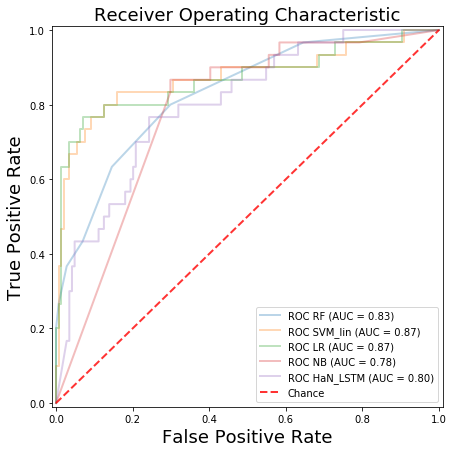

In [111]:
Roc(rocdicts_val2,"Combival")

In [123]:
indiCombi=np.argsort(forest_importance_val2)[-100:]

In [124]:
X_col_val2[indiCombi]

array(['mexico', 'sunnyval', 'scrap', 'sooner', 'graphic', 'buford',
       'ntsc', 'consider', 'china', 'harco', 'african', 'method', 'ramp',
       'twelv', 'tigerdirect', 'exact', 'enesco', 'intercept',
       'overallot', 'bullet', 'aust', 'deviat', 'mda_uncertainty_score',
       'unsubordin', 'trial', 'carn', 'mileston', 'caus', 'riot', 'ca',
       'SG.A.Expense', 'notch', 'enteron', 'sarban', 'wholli', 'deepwat',
       'Assets.Total', 'hold', 'spread', 'brick', 'numer', 'ci',
       'inopportun', 'larg', 'obsolet', 'strateg', 'tight', 'confidenti',
       'pursu', 'italian', 'mortal', 'franchise', 'emc', 'medic',
       'revamp', 'debar', 'truck', 'mda_uncertainty_word_proportion',
       'intranet', 'atlant', 'diagnost', 'crewboat', 'integr', 'reliabl',
       'america', 'op', 'aim', 'jurisdict', 'defect', 'rp',
       'CurrLiabsTot', 'InventoryPrx', 'modestli', 'forens', 'contact',
       'past', 'aerospac', 'Oper.Act.NCF', 'peopl', 'DeprAmortTot',
       'apac', 'copier', '

In [120]:
indices=np.argsort(BLforest_importance_val2)[-20:]

In [122]:
BLX_col_val2[indices]

array(['AverageTA', 'InventTotQtl', 'dWC_Accruals', 'DeprAmortTot', 'CFF',
       'mda_uncertainty_word_proportion', 'Acc.Payables', 'ROA.finratio',
       'mda_positive_word_proportion', 'AmrtOfIntang', 'EBIT.Marginn',
       'mda_fog_index', 'mda_percentage_of_complex_words', 'CurrLiabsTot',
       'dInventories', 'Assets.Total', 'AccRec.DbtsT', 'ComSharOutst',
       'Comm.OrdinEQ', 'InventoryPrx'], dtype=object)

# Evaluation on Test Set

In [102]:
MLmodels_test3=CombiModelsEval("None",0,x2_train,x2_test,y2_train,y2_test)
#BMLmodels_test2=CombiModelsEval("None",0,x2_train,x2_test,y2_train,y2_test)
Baselinemodels_test3=Baseline("None",0,x2_train,x2_test,y2_train,y2_test)
#CompOnlyBaselinemodels_test2=Baseline("None",0,x2_train,x2_test,y2_train,y2_test)

(814, 18088)


/home/RDC/crajapax/.conda/envs/kerasspring/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/RDC/crajapax/.conda/envs/kerasspring/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(814, 61)


/home/RDC/crajapax/.conda/envs/kerasspring/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/RDC/crajapax/.conda/envs/kerasspring/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [103]:
resultsdict_test3,rocdicts_test3,forest_importance_test3,X_col_test3=MLmodels_test3
#,rf_importance_test,Xcol2=MLmodels_test
#Bresultsdict_test2,Brocdicts_test2,Bforest_importance_test2=BMLmodels_test2
BLresultsdict_test3,BLrocdicts_test3,BLforest_importance_test3,BL_Col3=Baselinemodels_test3
#CBLresultsdict_test2,CBLrocdicts_test2,CBLforest_importance_test2=CompOnlyBaselinemodels_test2

In [104]:
resultsdict_test3["HaN_LSTM"]=(score_test,sensitivity_test,specificity_test,acc_test)
rocdicts_test3["HaN_LSTM"]=(y_test1,y_pred_test1)
BLresultsdict_test3["HaN_LSTM"]=(score_test,sensitivity_test,specificity_test,acc_test)
BLrocdicts_test3["HaN_LSTM"]=(y_test1,y_pred_test1)
#Bresultsdict_test2["HaN_LSTM"]=(score_test,sensitivity_test,specificity_test,acc_test)
#Brocdicts_test2["HaN_LSTM"]=(y_test1,y_pred_test1)
#CBLresultsdict_test2["HaN_LSTM"]=(score_test,sensitivity_test,specificity_test,acc_test)
#CBLrocdicts_test2["HaN_LSTM"]=(y_test1,y_pred_test1)

In [105]:
PerformanceSummary(resultsdict_test3)

,RF,SVM_lin,LR,NB,HaN_LSTM
roc_auc,0.850345,0.909425,0.931264,0.840920,0.802299
sensitivity,0.333333,0.800000,0.833333,0.933333,0.000000
specificity,0.993103,0.951724,0.965517,0.744828,1.000000
accuracy,0.880000,0.925714,0.942857,0.777143,0.828571


In [115]:
BLresultsdict_test3

{'RF': (0.7706896551724137, 0.1, 0.9862068965517241, 0.8342857142857143),
 'SVM_lin': (0.7360919540229884, 0.0, 1.0, 0.8285714285714286),
 'LR': (0.6841379310344827, 0.0, 1.0, 0.8285714285714286),
 'NB': (0.45839080459770115, 0.0, 0.993103448275862, 0.8228571428571428),
 'HaN_LSTM': (0.8022988505747126, 0.0, 1.0, 0.8285714387893677)}

In [106]:
#Compustat plus nur Ling Variables
PerformanceSummary(BLresultsdict_test3)

,RF,SVM_lin,LR,NB,HaN_LSTM
roc_auc,0.770690,0.736092,0.684138,0.458391,0.802299
sensitivity,0.100000,0.000000,0.000000,0.000000,0.000000
specificity,0.986207,1.000000,1.000000,0.993103,1.000000
accuracy,0.834286,0.828571,0.828571,0.822857,0.828571


In [116]:
PerformanceSummary(BLresultsdict_test3).to_latex(path+"BLtest.tex")
save_obj(BLresultsdict_test3,"BLresultsdict_test3")

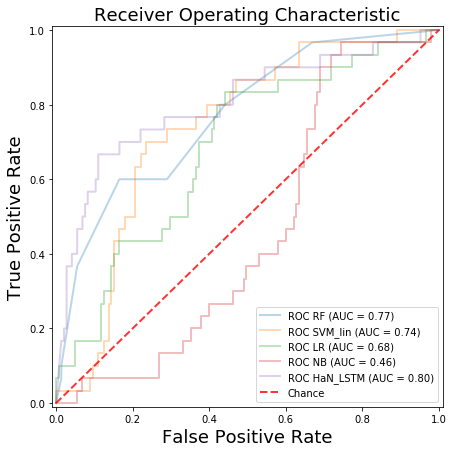

In [117]:
Roc(BLrocdicts_test3,"BLtest")

In [90]:
def Roc(rocdicts,name): 
    
    plt.figure(figsize=(7,7))
        
    # Compute ROC curve and area under the curve
    for model in rocdicts:
        a,b=rocdicts[model]
        fpr, tpr, thresholds = roc_curve(a,b)
        roc_auc = auc(fpr, tpr)
      

        plt.plot(fpr, tpr, alpha=0.3,
                 label="ROC "+ model+ " (AUC = %0.2f)" % (roc_auc),lw=2)
        
        

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Receiver Operating Characteristic',fontsize=18)
    plt.legend(loc="lower right", prop={'size': 10})
    plt.savefig(path+name+".png")
    plt.show()


In [91]:
def PerformanceSummary(resultsdict):
    column_names = ["roc_auc",'sensitivity','specificity','accuracy']
    return pd.DataFrame(resultsdict, index=column_names)

In [92]:
def calculate_performance(y_val, y_pred_val,y_score):
    cm_val=confusion_matrix(y_val, y_pred_val)
    total_val = sum(sum(cm_val))
    acc_val2 = (cm_val[0, 0] + cm_val[1, 1]) / total_val
    specificity = cm_val[0, 0] / (cm_val[0, 0] + cm_val[0, 1])
    sensitivity = cm_val[1, 1] / (cm_val[1, 0] + cm_val[1, 1])
  
    #specificity = np.sum(true_negatives) / np.sum(actual_negatives)

    #recall = recall_score(y_val, y_pred_val)
    accuracy=accuracy_score(y_val, y_pred_val)
    fpr, tpr, t = roc_curve(y_val, y_score)
    roc_auc = auc(fpr, tpr)
    #roc_auc_score2 =roc_auc_score(y_val,y_pred_val)
    #roc auc score und roc_auc sind das gleiche
    return (roc_auc,sensitivity,specificity,accuracy)

In [93]:
def Baseline(featureselection,number_of_chi2features,X_train,X_test,y_train,y_test):

    XC_train, XC_test= X_train.drop("pre2", axis=1), X_test.drop("pre2", axis=1)
    # create a count vectorizer object 
    #count = CountVectorizer(analyzer='word',stop_words='english')

    # transform the training and validation data using count vectorizer object
    #XT_train =  count.fit_transform(X_train["preV2"])
    #XT_test =  count.transform(X_test["preV2"])
    X_train=XC_train
    X_test=XC_test
    print(X_train.shape)
    Xcol=np.array(XC_train.columns)
       

    if (featureselection=="chi2"):
        chi2_selector = SelectKBest(chi2, k=number_of_chi2features)
           
        X_train = chi2_selector.fit_transform(X_train,y_train)
        X_test=X_test[:,chi2_selector.get_support()]
        chi2importance=chi2_selector.get_support()

    elif (featureselection=="None"):
        X_train=X_train


    # %% Random forests
    forest = RandomForestClassifier().fit(X_train, y_train)
    forest_importance = forest.feature_importances_

    y_predF = forest.predict(X_test)
    #print(y_pred)
    #print(y_test)
    y_scoreF=forest.predict_proba(X_test)
    y_score1F=y_scoreF[:,1]
    #print(y_score)
    #print(y_score1)
    forest_results = calculate_performance(y_test, y_predF,y_score1F)
    forest_rocdict=(y_test,y_score1F)
        
    # %% Random forests with ModelSelection
    #sel = SelectFromModel(RandomForestClassifier(n_estimators = 1000)).fit(X_train, y_train)
    #X_important_train = sel.transform(X_train)
    #X_important_test = sel.transform(X_test)
    #rf_important = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
    #rf_important.fit(X_important_train, y_train)
    #rf_importance = rf_important.feature_importances_
    #y_important_pred = rf_important.predict(X_important_test)
    #y_important_score=rf_important.predict_proba(X_important_test)[:,1]
    #rf_results = calculate_performance(y_test, y_important_pred,y_important_score)
    #rf_rocdict=(y_test, y_important_score)

    # %% SVM (Support Vector Machine) Linear
    svm = SVC(kernel='linear',probability=True).fit(X_train, y_train)
    y_predS = svm.predict(X_test)    
    y_scoreS=svm.predict_proba(X_test)[:,1]
    svm_results_linear = calculate_performance(y_test, y_predS,y_scoreS)
    
    svm_lin_rocdict=(y_test, y_scoreS)

    # %% SVM (Support Vector Machine) RBF
    #svm = SVC(kernel='rbf',probability=True).fit(X_train, y_train)  
    #y_pred = svm.predict(X_test)   
    #y_score=svm.predict_proba(X_test)[:,1]
    #svm_results_rbf = calculate_performance(y_test, y_pred,y_score)
    #svm_rbf_rocdict=(y_test, y_score)
        
    # %% Logistic Regression
    lr = LogisticRegression().fit(X_train, y_train)   
    y_predL = lr.predict(X_test) 
    y_scoreL=lr.predict_proba(X_test)[:,1]
    lr_results = calculate_performance(y_test, y_predL,y_scoreL)
    lr_rocdict=(y_test, y_scoreL)
        
    # %% Naive Bayes
    clf = MultinomialNB().fit(X_train, y_train)
    y_predN = clf.predict(X_test)   
    y_scoreN=clf.predict_proba(X_test)[:,1]
    nb_results = calculate_performance(y_test, y_predN,y_scoreN)
    nb_rocdict=(y_test, y_scoreN)

    resultsdict={"RF": forest_results,
                #"RFModelSelection": rf_results,
                "SVM_lin" : svm_results_linear,
                #"SVM_rbf" : svm_results_rbf,
                "LR" :lr_results,
                "NB" : nb_results}
    rocdicts={"RF": forest_rocdict, 
                #"RFModelSelection": rf_rocdict,          
                "SVM_lin" : svm_lin_rocdict,
                #"SVM_rbf" : svm_rbf_rocdict,
                "LR" :lr_rocdict,
                "NB" : nb_rocdict}

    return resultsdict,rocdicts,forest_importance,Xcol
#,rf_importance,Xcol

In [94]:
def CombiModelsEval(featureselection,number_of_chi2features,X_train,X_test,y_train,y_test):

    XC_train, XC_test= X_train.drop("pre2", axis=1), X_test.drop("pre2", axis=1)
    # create a count vectorizer object 
    count = CountVectorizer(analyzer='word',max_df=0.85,stop_words='english',max_features=20000)

    # transform the training and validation data using count vectorizer object
    XT_train =  count.fit_transform(X_train["pre2"])
    XT_test =  count.transform(X_test["pre2"])
    X_train=hstack([XT_train,XC_train]).todense()
    X_test=hstack([XT_test,XC_test]).todense()
    print(X_train.shape)
    Xcol=np.concatenate((np.array(count.get_feature_names()), np.array(XC_train.columns)), axis=0)
       

    if (featureselection=="chi2"):
        chi2_selector = SelectKBest(chi2, k=number_of_chi2features)
           
        X_train = chi2_selector.fit_transform(X_train,y_train)
        X_test=X_test[:,chi2_selector.get_support()]
        chi2importance=chi2_selector.get_support()

    elif (featureselection=="None"):
        X_train=X_train


    # %% Random forests
    forest = RandomForestClassifier().fit(X_train, y_train)
    forest_importance = forest.feature_importances_

    y_predF = forest.predict(X_test)
    #print(y_pred)
    #print(y_test)
    y_scoreF=forest.predict_proba(X_test)
    y_score1F=y_scoreF[:,1]
    #print(y_score)
    #print(y_score1)
    forest_results = calculate_performance(y_test, y_predF,y_score1F)
    forest_rocdict=(y_test,y_score1F)
        
    # %% Random forests with ModelSelection
    #sel = SelectFromModel(RandomForestClassifier(n_estimators = 1000)).fit(X_train, y_train)
    #X_important_train = sel.transform(X_train)
    #X_important_test = sel.transform(X_test)
    #rf_important = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
    #rf_important.fit(X_important_train, y_train)
    #rf_importance = rf_important.feature_importances_
    #y_important_pred = rf_important.predict(X_important_test)
    #y_important_score=rf_important.predict_proba(X_important_test)[:,1]
    #rf_results = calculate_performance(y_test, y_important_pred,y_important_score)
    #rf_rocdict=(y_test, y_important_score)

    # %% SVM (Support Vector Machine) Linear
    svm = SVC(kernel='linear',probability=True).fit(X_train, y_train)
    y_predS = svm.predict(X_test)    
    y_scoreS=svm.predict_proba(X_test)[:,1]
    svm_results_linear = calculate_performance(y_test, y_predS,y_scoreS)
    
    svm_lin_rocdict=(y_test, y_scoreS)

    # %% SVM (Support Vector Machine) RBF
    #svm = SVC(kernel='rbf',probability=True).fit(X_train, y_train)  
    #y_pred = svm.predict(X_test)   
    #y_score=svm.predict_proba(X_test)[:,1]
    #svm_results_rbf = calculate_performance(y_test, y_pred,y_score)
    #svm_rbf_rocdict=(y_test, y_score)
        
    # %% Logistic Regression
    lr = LogisticRegression().fit(X_train, y_train)   
    y_predL = lr.predict(X_test) 
    y_scoreL=lr.predict_proba(X_test)[:,1]
    lr_results = calculate_performance(y_test, y_predL,y_scoreL)
    lr_rocdict=(y_test, y_scoreL)
        
    # %% Naive Bayes
    clf = MultinomialNB().fit(X_train, y_train)
    y_predN = clf.predict(X_test)   
    y_scoreN=clf.predict_proba(X_test)[:,1]
    nb_results = calculate_performance(y_test, y_predN,y_scoreN)
    nb_rocdict=(y_test, y_scoreN)

    resultsdict={"RF": forest_results,
                #"RFModelSelection": rf_results,
                "SVM_lin" : svm_results_linear,
                #"SVM_rbf" : svm_results_rbf,
                "LR" :lr_results,
                "NB" : nb_results}
    rocdicts={"RF": forest_rocdict, 
                #"RFModelSelection": rf_rocdict,          
                "SVM_lin" : svm_lin_rocdict,
                #"SVM_rbf" : svm_rbf_rocdict,
                "LR" :lr_rocdict,
                "NB" : nb_rocdict}

    return resultsdict,rocdicts,forest_importance,Xcol
#,rf_importance,Xcol

In [95]:
def CombiModelsEval2(featureselection,number_of_chi2features,X_train,X_test,y_train,y_test):

    XC_train, XC_test= X_train.drop("pre2", axis=1), X_test.drop("pre2", axis=1)
    # create a count vectorizer object 
    #count = CountVectorizer(analyzer='word',stop_words='english')
    tfidf_vect = TfidfVectorizer(analyzer='word',stop_words='english')
    # transform the training and validation data using count vectorizer object
    XT_train =  tfidf_vect.fit_transform(X_train["pre2"])
    XT_test =  tfidf_vect.transform(X_test["pre2"])
    X_train=hstack([XT_train,XC_train]).todense()
    X_test=hstack([XT_test,XC_test]).todense()
    print(X_train.shape)
    Xcol=np.concatenate((np.array(tfidf_vect.get_feature_names()), np.array(XC_train.columns)), axis=0)
       

    if (featureselection=="chi2"):
        chi2_selector = SelectKBest(chi2, k=number_of_chi2features)
           
        X_train = chi2_selector.fit_transform(X_train,y_train)
        X_test=X_test[:,chi2_selector.get_support()]
        chi2importance=chi2_selector.get_support()

    elif (featureselection=="None"):
        X_train=X_train


    # %% Random forests
    forest = RandomForestClassifier().fit(X_train, y_train)
    forest_importance = forest.feature_importances_

    y_predF = forest.predict(X_test)
    #print(y_pred)
    #print(y_test)
    y_scoreF=forest.predict_proba(X_test)
    y_score1F=y_scoreF[:,1]
    #print(y_score)
    #print(y_score1)
    forest_results = calculate_performance(y_test, y_predF,y_score1F)
    forest_rocdict=(y_test,y_score1F)
        
    # %% SVM (Support Vector Machine) Linear
    svm = SVC(kernel='linear',probability=True).fit(X_train, y_train)
    y_predS = svm.predict(X_test)    
    y_scoreS=svm.predict_proba(X_test)[:,1]
    svm_results_linear = calculate_performance(y_test, y_predS,y_scoreS)
    
    svm_lin_rocdict=(y_test, y_scoreS)

        
    # %% Logistic Regression
    lr = LogisticRegression().fit(X_train, y_train)   
    y_predL = lr.predict(X_test) 
    y_scoreL=lr.predict_proba(X_test)[:,1]
    lr_results = calculate_performance(y_test, y_predL,y_scoreL)
    lr_rocdict=(y_test, y_scoreL)
        
    # %% Naive Bayes
    clf = MultinomialNB().fit(X_train, y_train)
    y_predN = clf.predict(X_test)   
    y_scoreN=clf.predict_proba(X_test)[:,1]
    nb_results = calculate_performance(y_test, y_predN,y_scoreN)
    nb_rocdict=(y_test, y_scoreN)

    resultsdict={"RF": forest_results,
                #"RFModelSelection": rf_results,
                "SVM_lin" : svm_results_linear,
                #"SVM_rbf" : svm_results_rbf,
                "LR" :lr_results,
                "NB" : nb_results}
    rocdicts={"RF": forest_rocdict, 
                #"RFModelSelection": rf_rocdict,          
                "SVM_lin" : svm_lin_rocdict,
                #"SVM_rbf" : svm_rbf_rocdict,
                "LR" :lr_rocdict,
                "NB" : nb_rocdict}

    return resultsdict,rocdicts,forest_importance,Xcol
#,rf_importance

In [29]:
Han2 = model1[0].fit([x_train,XQ_train], y_train, validation_data=([x_val,XQ_val], y_val), epochs=3, batch_size=32,callbacks=[RocAuc,checkpointer])


NameError: name 'model1' is not defined

In [78]:
sentEncoder = Model(inputs = sent_input,outputs = sent_att)
doc1=sentEncoder.predict((np.resize(data[1],(1,max_sentences,maxlen))))

In [80]:
doc1=sentEncoder.predict((np.resize(data[1],(1,max_sentences,maxlen))))

In [86]:
sentEncoder[1]

TypeError: 'Model' object does not support indexing

In [66]:
sent_att[10000]

Subtensor{int64}.0

In [43]:
sent_att[2].reshape

<bound method _tensor_py_operators.reshape of Subtensor{int64}.0>

In [54]:
K.reshape(sent_att,(2,6))

Reshape{2}.0

In [57]:
sent_att.type

TensorType(float32, matrix)

In [44]:
svm = SVC(kernel='linear',probability=True).fit(sent_att, y_train)
y_predS = svm.predict(X_test)    
y_scoreS=svm.predict_proba(X_test)[:,1]
svm_results_linear = calculate_performance(y_test, y_predS,y_scoreS)

ValueError: setting an array element with a sequence.

In [58]:
type(sent_att)

theano.tensor.var.TensorVariable

In [54]:
sent_att[0].eval()

MissingInputError: Input 0 of the graph (indices start from 0), used to compute Reshape{2}(/sent_input, TensorConstant{[-1 38]}), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.
 
Backtrace when that variable is created:

  File "/home/RDC/crajapax/.conda/envs/kerasspring/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/RDC/crajapax/.conda/envs/kerasspring/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/RDC/crajapax/.conda/envs/kerasspring/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-7e492e76391c>", line 17, in <module>
    sent_input = Input(shape=(max_sentences,maxlen), dtype='int32',name='sent_input')
  File "/home/RDC/crajapax/.conda/envs/kerasspring/lib/python3.6/site-packages/keras/engine/input_layer.py", line 178, in Input
    input_tensor=tensor)
  File "/home/RDC/crajapax/.conda/envs/kerasspring/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/RDC/crajapax/.conda/envs/kerasspring/lib/python3.6/site-packages/keras/engine/input_layer.py", line 87, in __init__
    name=self.name)
  File "/home/RDC/crajapax/.conda/envs/kerasspring/lib/python3.6/site-packages/keras/backend/theano_backend.py", line 254, in placeholder
    x = T.TensorType(dtype, broadcast)(name)


In [55]:
import theano
import theano.tensor as T
import numpy as np

class testxx(object):
    def __init__(self, input):
        self.input = input
        self.output = T.sum(input)
a = T.matrix(dtype=theano.config.floatX)
classfier = testxx(a)
outxx = classfier.output
f = theano.function([a], outxx)
outxx = f(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype = np.float32))

In [69]:
classfier = testxx(sent_att)
outxx = classfier.output
f = theano.function([sent_att], outxx)
#outxx = f(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype = np.float32))

In [73]:
classfier

In [64]:
sent_att.type

TensorType(float32, matrix)

In [63]:
npy

<bound method Variable.eval of Sum{axis=[1], acc_dtype=float64}.0>